## Dropout : A simple way to Prevent Neural Networks from Overfitting


In this notebook, we experiment with dropouts on MNIST data set. The aim is recreate the experiment results given in section 6.1.1 in the paper https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf

This section compares the neural networks with and without dropouts for MNIST dataset.

MNIST dataset is available with Keras. It consists of 28 x 28 pixel handwritten digit images.


In [1]:
from keras.datasets import mnist


(x_train, y_train), (x_test, y_test) = mnist.load_data()

print("x_train shape {}".format(x_train.shape))
print("y_train shape {}".format(y_train.shape))
print("x_test shape {}".format(x_test.shape))
print("x_train shape {}".format(y_test.shape))



Using TensorFlow backend.


11493376/11490434 [==============================] - 2s 0us/step
x_train shape (60000, 28, 28)
y_train shape (60000,)
x_test shape (10000, 28, 28)
x_train shape (10000,)


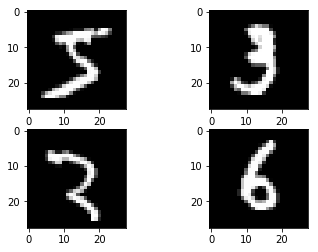

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplot(221)
plt.imshow(x_train[0], cmap = plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(x_train[10], cmap = plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(x_train[500], cmap = plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(x_train[1020], cmap = plt.get_cmap('gray'))
plt.show()

In [10]:
from keras.utils import np_utils

## One hot encoder
train_one_hot =  np_utils.to_categorical(y_train)
test_one_hot  = np_utils.to_categorical(y_test)

print("train one hot shapec {}".format(train_one_hot.shape))

train one hot shapec (60000, 10)


In [2]:
input_dim = x_train.shape[1:]
input_dim

(28, 28)

## Model 1 

28 x 28 --- Flatten --> 784 --Dense--> 1024, Relu --Dense--> 1024, Relu --softmax--> 10 

In [32]:
from keras import layers
from keras.layers import Input, Dense, Activation, Flatten
from keras.callbacks import History, EarlyStopping
from keras.models import Model 
import numpy as np
np.random.seed(123)


batch_size = 256
epochs = 25
# Stop the training if the accuracy is not moving more than a delta
# keras.callbacks.History is by default added to all keras model
callbacks = [EarlyStopping(monitor='acc', min_delta=0.01, patience=0, verbose=0, mode='auto')]

# Code up the network
x_input = Input(input_dim)
x = Flatten()(x_input)
x = Dense(1024, activation='relu', name ="dense1")(x)
x = Dense(1024, activation='relu', name = "dense2")(x)
predictions = Dense(10, activation='softmax')(x)

# Create and train model
model = Model(inputs = x_input, outputs = predictions)
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(x_train, train_one_hot, batch_size = batch_size,callbacks = callbacks ,epochs = epochs, verbose = 1)


Epoch 1/5
60000/60000 [==============================] - 8s 137us/step - loss: 10.5502 - acc: 0.3435
Epoch 2/5
60000/60000 [==============================] - 8s 136us/step - loss: 6.9548 - acc: 0.5671
Epoch 3/5
60000/60000 [==============================] - 8s 135us/step - loss: 6.7685 - acc: 0.5788
Epoch 4/5
60000/60000 [==============================] - 8s 133us/step - loss: 6.6885 - acc: 0.5842


In [33]:
hist.history.keys()

dict_keys(['loss', 'acc'])

Text(0,0.5,'accuracy')

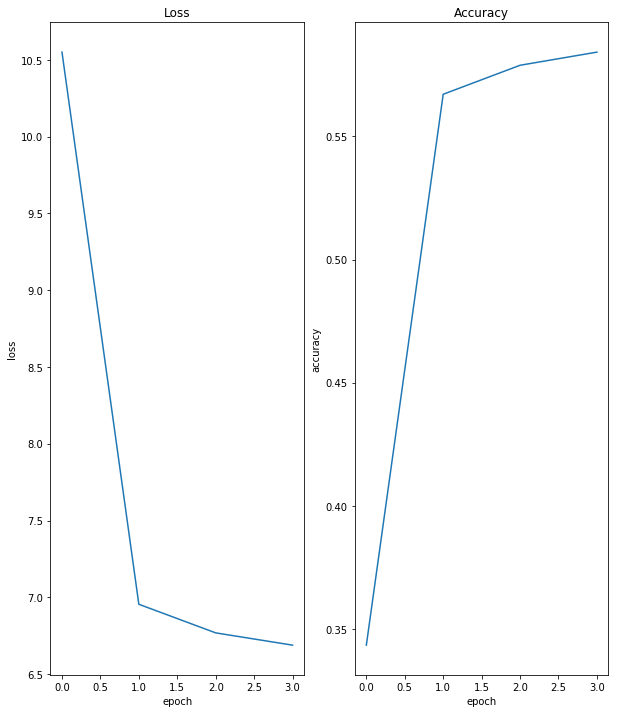

In [34]:
fig = plt.figure(figsize=(10,12))
plt.tight_layout()
plt.subplot(121)
plt.plot(hist.history['loss'])
plt.title("Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.subplot(122)
plt.plot(hist.history['acc'])
plt.title("Accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")


In [42]:
## Evaluate the model on train and test
metrics = model.evaluate(x=x_train, y=train_one_hot, batch_size=batch_size, verbose=1, sample_weight=None, steps=None)
print("Train Evaluation")
for k,v in zip(model.metrics_names,metrics):
    print (k,v)

print("Test Evaluation")
metrics = model.evaluate(x=x_test, y=test_one_hot, batch_size=batch_size, verbose=1, sample_weight=None, steps=None)
for k,v in zip(model.metrics_names,metrics):
    print (k,v)



60000/60000 [==============================] - 3s 48us/step
loss 6.62423739726
acc 0.588183333302
10000/10000 [==============================] - 0s 49us/step
loss 6.56843814926
acc 0.5922
